In [1]:
from data.loaders import load_reddit_data
from preprocessing import RedditText

In [2]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import pandas as pd

# Loading in data

In [3]:
submissions, comments = load_reddit_data()

# Assessment of data quality

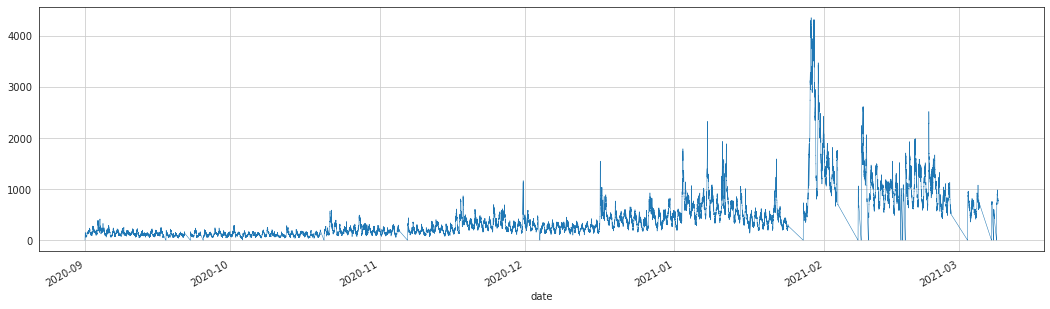

In [4]:
frequency = comments.id.rolling("1h").count()
frequency.plot(figsize=(18,5), linewidth=0.5)
plt.grid()

In [5]:
starts = frequency.loc[frequency==1].reset_index().drop(columns="id").rename(columns={"date":"start"})
ends = frequency.loc[frequency.shift(-1)==1].reset_index().drop(columns="id").rename(columns={"date":"end clean block"})
print(pd.concat([ends, (starts.start.shift(-1) - ends.loc[:,"end clean block"]).rename("duration")], axis=1).dropna().to_latex())

\begin{tabular}{llr}
\toprule
{} &     end clean block &        duration \\
\midrule
0  & 2020-09-17 06:40:01 & 0 days 11:34:54 \\
1  & 2020-09-21 15:35:41 & 1 days 03:52:15 \\
2  & 2020-09-24 23:21:38 & 0 days 11:38:54 \\
3  & 2020-10-19 16:58:22 & 0 days 18:37:11 \\
4  & 2020-11-05 00:38:13 & 1 days 17:43:01 \\
5  & 2020-12-03 17:57:16 & 0 days 09:50:02 \\
6  & 2021-01-24 13:06:23 & 3 days 02:50:28 \\
7  & 2021-02-03 20:17:50 & 4 days 04:03:33 \\
8  & 2021-02-08 04:22:18 & 0 days 11:21:54 \\
9  & 2021-02-09 21:03:47 & 0 days 06:27:48 \\
10 & 2021-02-16 15:02:45 & 0 days 06:22:41 \\
11 & 2021-02-16 23:28:12 & 0 days 07:14:16 \\
12 & 2021-02-17 11:47:15 & 0 days 06:50:28 \\
13 & 2021-02-27 06:08:52 & 3 days 10:16:06 \\
14 & 2021-03-05 01:36:42 & 2 days 13:40:31 \\
15 & 2021-03-07 18:01:11 & 0 days 07:02:31 \\
16 & 2021-03-08 05:26:51 & 0 days 10:48:22 \\
\bottomrule
\end{tabular}



# Cleaning dataset

In [6]:
try:
    cleanreddit = RedditText("cleanreddit")
    print("loading from cleaned file")
except:
    print("failed, generate cleaned file")
    reddit = RedditText(comments.body)
    cleanreddit = reddit.clean_corpus(save_as="cleanreddit")

loading from cleaned file


<AxesSubplot:ylabel='Frequency'>

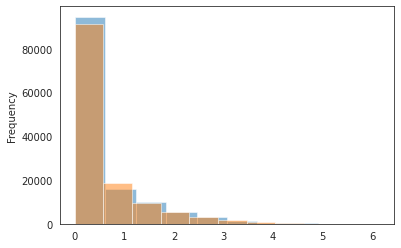

In [7]:
cleanreddit.cfs().wordcount.apply(np.log10).plot(kind="hist", alpha=0.5)
cleanreddit.dfs().wordcount.apply(np.log10).plot(kind="hist", alpha=0.5)

In [8]:
cleanreddit.cfs().tail(25)

,token,wordcount
358,buy,125074
300,don,128042
228,people,131644
261,there,136293
247,more,138576
124,all,146560
162,like,150736
195,what,155853
34,just,191538
97,will,194405


In [9]:
cleanreddit.cfs().loc[cleanreddit.cfs().wordcount<=2].tail(25)

,token,wordcount
56383,tagger,2
110032,posy,2
59125,mcchickens,2
71160,fourties,2
28967,immuculation,2
71171,thumbstick,2
97948,publicaciones,2
59031,righty,2
95790,abezzy,2
95773,jogged,2


In [10]:
cleanreddit.dictionary.filter_extremes(2, 0.9)

# Looking at topics

In [11]:
buzzwords = ["long", "buy", "moon", "pump", "bullish", "sell", "hodl", "hold", "dump", "bearish", "bear"]

In [12]:
try:
    print("try to load model")
    w2v = cleanreddit.train_word2vec("reddit_w2v50")
except:
    print("failed, start training")
    w2v = cleanreddit.train_word2vec(cleanreddit.corpus, vector_size=25, save_as="reddit_w2v50")

try to load model


In [13]:
sim_words = cleanreddit.more_context(w2v, buzzwords, verbose=False)
sim_words

{'long': [('short', 0.8584361672401428),
  ('girofx', 0.7478005886077881),
  ('versiin', 0.7327905893325806),
  ('endearment', 0.7311340570449829),
  ('engravements', 0.7290434241294861)],
 'buy': [('sell', 0.9041133522987366),
  ('trade', 0.8502083420753479),
  ('invest', 0.8360731601715088),
  ('move', 0.8052030801773071),
  ('accumulate', 0.8050544261932373)],
 'moon': [('moonn', 0.792546272277832),
  ('pluto', 0.751807689666748),
  ('mar', 0.7516126036643982),
  ('rocket', 0.7218918204307556),
  ('baby', 0.7039923667907715)],
 'pump': [('dump', 0.9698787927627563),
  ('rally', 0.8253246545791626),
  ('pnd', 0.8218971490859985),
  ('moonshot', 0.7801559567451477),
  ('spike', 0.761981189250946)],
 'bullish': [('bearish', 0.9254222512245178),
  ('overbought', 0.8850116729736328),
  ('overextended', 0.8404366374015808),
  ('hopeful', 0.8020867705345154),
  ('optimistic', 0.8011513948440552)],
 'sell': [('buy', 0.9041133522987366),
  ('liquidate', 0.8507047295570374),
  ('rebuy', 0.838

In [14]:
extension = [element[0] for key in sim_words for element in sim_words[key] if element[1]>=0.75]
extension

['short',
 'sell',
 'trade',
 'invest',
 'move',
 'accumulate',
 'moonn',
 'pluto',
 'mar',
 'dump',
 'rally',
 'pnd',
 'moonshot',
 'spike',
 'bearish',
 'overbought',
 'overextended',
 'hopeful',
 'optimistic',
 'buy',
 'liquidate',
 'rebuy',
 'hold',
 'trade',
 'hold',
 'hodling',
 'hodl',
 'sell',
 'buy',
 'invest',
 'liquidate',
 'pump',
 'whale',
 'rally',
 'pnd',
 'bullish',
 'overbought',
 'oversold',
 'euphoria',
 'euphoric',
 'bull',
 'timing',
 'squeeze',
 'cycle',
 'bullrun']

In [15]:
all_buzzwords = buzzwords + extension
all_buzzwords

['long',
 'buy',
 'moon',
 'pump',
 'bullish',
 'sell',
 'hodl',
 'hold',
 'dump',
 'bearish',
 'bear',
 'short',
 'sell',
 'trade',
 'invest',
 'move',
 'accumulate',
 'moonn',
 'pluto',
 'mar',
 'dump',
 'rally',
 'pnd',
 'moonshot',
 'spike',
 'bearish',
 'overbought',
 'overextended',
 'hopeful',
 'optimistic',
 'buy',
 'liquidate',
 'rebuy',
 'hold',
 'trade',
 'hold',
 'hodling',
 'hodl',
 'sell',
 'buy',
 'invest',
 'liquidate',
 'pump',
 'whale',
 'rally',
 'pnd',
 'bullish',
 'overbought',
 'oversold',
 'euphoria',
 'euphoric',
 'bull',
 'timing',
 'squeeze',
 'cycle',
 'bullrun']

61804 words in dictionary could be matched with w2v
0 words in dictionary could not be matched with w2v
compute a clustering only with respect to matched words

56 buzzwords could be matched with w2v
0 buzzwords could not be matched with w2v
compute clustering with 3 clusters
compute pca for plotting
Most similar words to centroid 0
     |     cosine similarity: 0.9887 | word: "oguglecchi"
     |     cosine similarity: 0.9879 | word: "individulism"
     |     cosine similarity: 0.9875 | word: "государством"
     |     cosine similarity: 0.9873 | word: "erorr"
     |     cosine similarity: 0.9866 | word: "kehmorf"
     |     cosine similarity: 0.985 | word: "jeremyrubin"
     |     cosine similarity: 0.985 | word: "bushstar"
     |     cosine similarity: 0.9848 | word: "pdkcshvifwplxmsip"
     |     cosine similarity: 0.9848 | word: "kristapsk"
     |     cosine similarity: 0.984 | word: "dueño"
Most similar words to centroid 1
     |     cosine similarity: 0.8479 | word: "decrease"
   

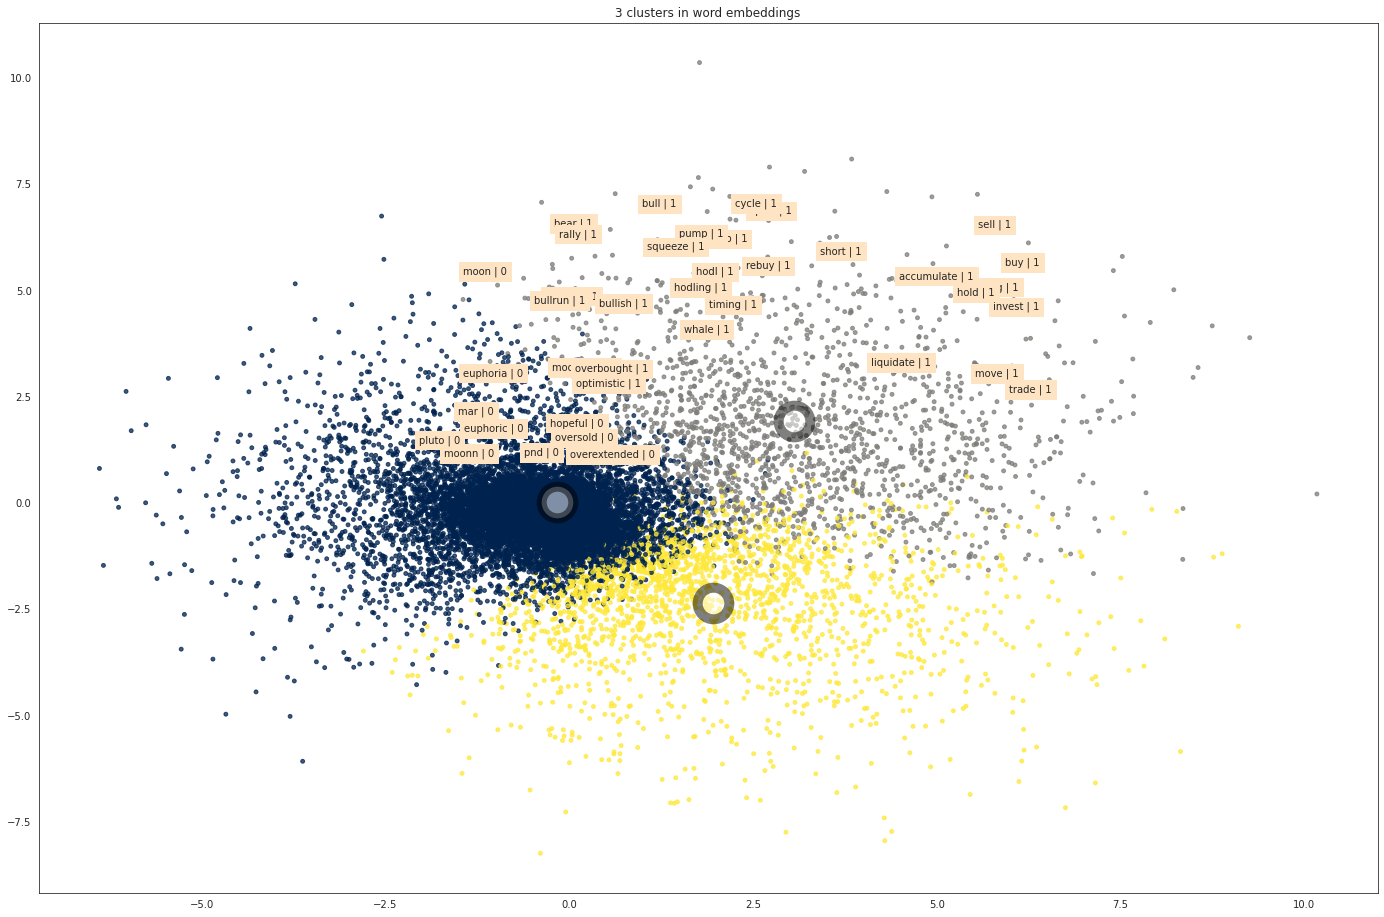

In [22]:
cluster_model, _ = cleanreddit.kmeans(cleanreddit.dictionary, w2v, buzzwords=all_buzzwords, n_clusters=3)

,long,buy,moon,pump,bullish,sell,hodl,hold,dump,bearish,...,bullish,overbought,oversold,euphoria,euphoric,bull,timing,squeeze,cycle,bullrun
long,1.000000,0.283376,0.260366,0.135259,0.411968,0.280906,0.452410,0.345810,0.156494,0.291590,...,0.411968,0.364907,0.261168,0.206261,0.145664,0.500438,0.223356,0.083494,0.393702,0.274185
buy,0.283376,1.000000,0.233942,0.405063,0.051466,0.904113,0.635070,0.791896,0.433441,-0.034274,...,0.051466,0.042576,-0.013255,-0.122913,-0.214669,-0.011787,0.196533,0.284079,0.117700,0.078177
moon,0.260366,0.233942,1.000000,0.495389,0.365399,0.292160,0.575817,0.395145,0.499240,0.297437,...,0.365399,0.235778,0.134844,0.377530,0.277828,0.488657,0.224104,0.208893,0.460526,0.481154
pump,0.135259,0.405063,0.495389,1.000000,0.369198,0.515502,0.322204,0.322399,0.969879,0.407044,...,0.369198,0.251282,0.117673,0.452880,0.244107,0.503577,0.268541,0.568835,0.505512,0.616246
bullish,0.411968,0.051466,0.365399,0.369198,1.000000,0.085562,0.224755,0.056667,0.351221,0.925422,...,1.000000,0.885012,0.785133,0.696517,0.798070,0.591093,0.507457,0.300946,0.503642,0.447753
sell,0.280906,0.904113,0.292160,0.515502,0.085562,1.000000,0.667910,0.822073,0.594096,0.073154,...,0.085562,0.106543,0.020285,0.013088,-0.112495,0.102791,0.268896,0.479893,0.187724,0.166849
hodl,0.452410,0.635070,0.575817,0.322204,0.224755,0.667910,1.000000,0.881142,0.354360,0.143670,...,0.224755,0.148749,0.099002,0.096118,0.053940,0.205032,0.380492,0.360731,0.236730,0.175177
hold,0.345810,0.791896,0.395145,0.322399,0.056667,0.822073,0.881142,1.000000,0.390828,-0.036656,...,0.056667,0.029631,-0.017159,-0.151099,-0.177916,0.037134,0.262284,0.367441,0.142877,0.019820
dump,0.156494,0.433441,0.499240,0.969879,0.351221,0.594096,0.354360,0.390828,1.000000,0.375310,...,0.351221,0.243664,0.094927,0.419878,0.253879,0.469473,0.219250,0.571881,0.456801,0.550920
bearish,0.291590,-0.034274,0.297437,0.407044,0.925422,0.073154,0.143670,-0.036656,0.375310,1.000000,...,0.925422,0.897909,0.826801,0.795835,0.792727,0.606030,0.562929,0.451570,0.552144,0.534865


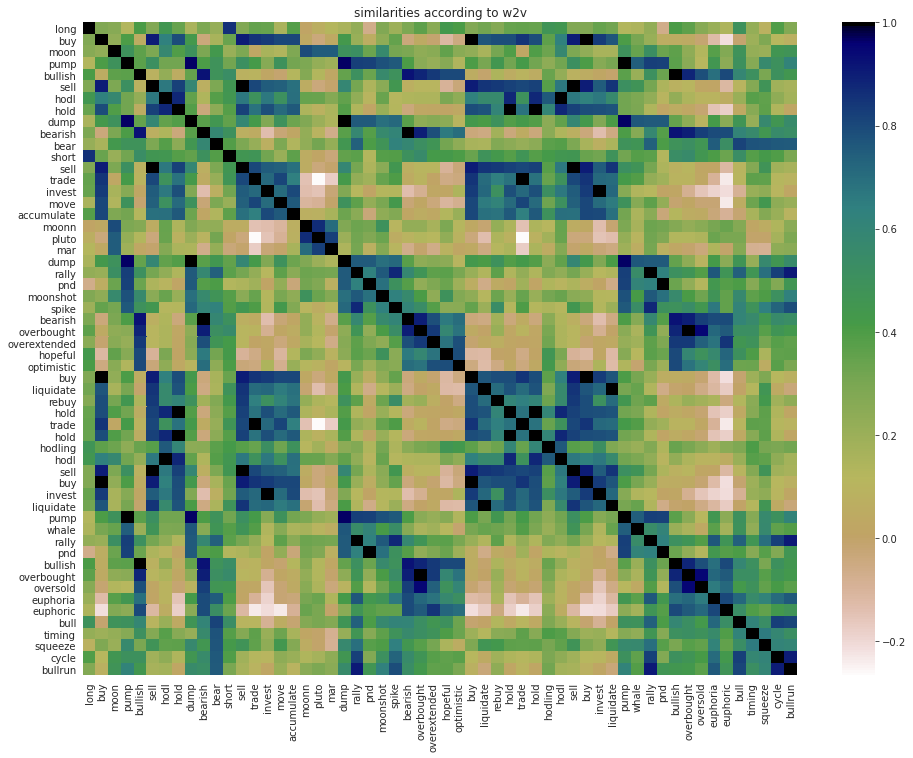

In [17]:
cleanreddit.same_context(w2v, all_buzzwords)

In [18]:
num_topics = 5
file_name = f"lda{num_topics}"

In [19]:
try:
    print("try loading lda")
    #lda, vis = cleanreddit.lda(cleanreddit.corpus, load=file_name)
except:
    print("failed, train lda")
    #lda, vis = cleanreddit.lda(cleanreddit.corpus, num_topics=num_topics, save_as=save_lda)

try loading lda


In [20]:
#vis

# look at movements of handcraftet topics over time

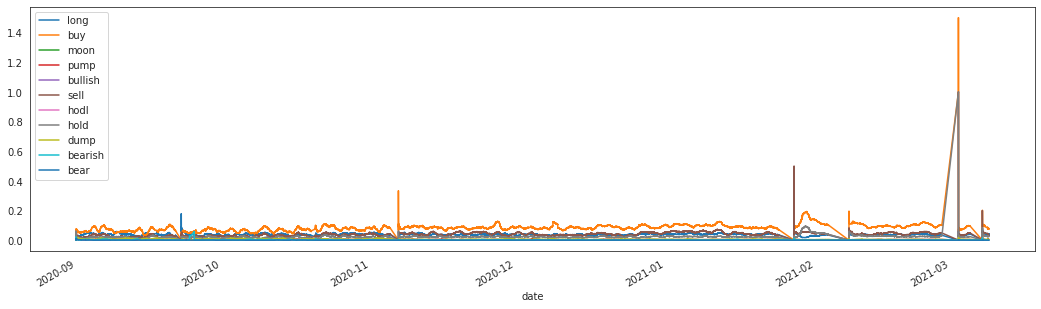

In [21]:
tracked = cleanreddit.track(buzzwords).rolling("1D").mean().plot(figsize=(18,5))